In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, average_precision_score
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE, ADASYN, SVMSMOTE
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import scikitplot as skplt
import matplotlib
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from collections import Counter

/Users/rlsma/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load data

ds = pd.read_csv('TRN', sep='\t')

In [3]:
# Select columns

features = ds.columns.drop(['INDEX', 'IND_BOM_1_1', 'IND_BOM_1_2'])
X = ds[features]
y = ds['IND_BOM_1_1']

In [5]:
#  Selecting features usign RandomForest

sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel = sel.fit(X,y)
X = sel.fit_transform(X,y)

In [6]:
# X = PCA(100).fit_transform(X)

In [7]:
# Converting X+y to Dataframe 

#  X = pd.DataFrame(data=X)
# y = pd.DataFrame(data=y)
# ds = pd.concat([X,y], axis=1)

# Generating heatmap of correlations

# import seaborn as sns
# import matplotlib.pyplot as plt

# corrmat = ds.corr()
# top_corr_features = corrmat.index
# plt.figure(figsize=(300,300))
# #plot heat map
# g=sns.heatmap(ds[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [8]:
# bestfeatures = SelectKBest(score_func=f_classif, k=50)
# X = bestfeatures.fit_transform(X, y)

In [9]:
# Separate data for train, validation and test
# Train: 1/2
# Validation: 1/4
# Test: 1/4

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, stratify=y, random_state=43)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=(2/3), stratify=y_train, random_state=44)

In [10]:
sm = ADASYN()
X_train, y_train = sm.fit_resample(X_train, y_train)

In [11]:
X_train, y_train = shuffle(X_train, y_train)

In [48]:
# Utility functions for testing models

# Accuracy: (TP + TN) / N
# Precision: TP / (TP + FP)
# Recall: TP / (TP + FN)
# F1-Measure: Harmonic average between Precision and Recall

def compute_metrics(pred, pred_probs, y, neg_class=0):
    cm = confusion_matrix(y_true=y, y_pred=pred)
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    acc = (tp+tn) / (tp+tn+fp+fn)
    f_measure = f1_score(y, pred)
    
    pred_probs = np.array([v[0] if v[0] > v[1] else v[1] for v in pred_probs])
    roc_auc = roc_auc_score(y, pred_probs)
    pr_auc = average_precision_score(y, pred_probs)
    gd = generate_dist(pred_probs, np.array(y), neg_class)
    ks = ks_2samp(gd[0], gd[1])[0]
    return acc, precision, recall, f_measure, roc_auc, pr_auc, ks, cm

def report_performance_metrics(pred, pred_probs, _y, neg_class=0):
    acc, prec, rec, f_measure, roc_auc, pr_auc, ks, cm = compute_metrics(pred, pred_probs, _y, neg_class)
    skplt.metrics.plot_ks_statistic(_y, pred_probs)
    plt.show()
    skplt.metrics.plot_roc_curve(_y, pred_probs, curves=["each_class"])
    plt.show()
    print('Accuracy:', acc)
    print('Precision:', prec)
    print('Recall:', rec)
    print('F-Measure:', f_measure)
    print('AUROC:', roc_auc)
    print('AUPR:', pr_auc)
    print('Confusion Matrix:')
    print(cm)
    
def train_test_k_fold(k, clf, _X, _y, neg_class=0):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)
    it = 1
    for train_index, test_index in skf.split(_X, _y):
        X_batch = _X[train_index]
        y_batch = _y[train_index]
        X_test_batch = _X[test_index]
        y_test_batch = _y[test_index]
        clf.fit(X_batch, y_batch)
        results = clf.predict(X_test_batch)
        results_probs = clf.predict_proba(X_test_batch)
        print('K Fold it', it)
        report_performance_metrics(results, results_probs, y_test_batch, neg_class)
        print('')
        it += 1
        
def test_model(clf, _X, _y):
    results = clf.predict(_X)
    results_probs = clf.predict_proba(_X)
    report_performance_metrics(results, results_probs, _y)
    
def generate_dist(probas, y, neg_class):
    dist_1 = [0] * 100
    dist_2 = [0] * 100
    for_perc = Counter(y)
    for i in range(1,101):
        limiar = i/100        
        lower = y[np.where(probas <= limiar)]
        count = Counter(lower)
        dist_1[i-1] = count[neg_class]
        dist_2[i-1] = count[1]
    return np.array(dist_1)/for_perc[neg_class], np.array(dist_2)/for_perc[1]

In [13]:
#_X_train = np.delete(X_train, cat_cols, 1)
#kk = np.delete(X_val, cat_cols, 1)

In [14]:
'''params = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': [.0001, .01, 1, 10, 100],
    'gamma': [.0001, .001, .01, .1, 1, 10, 100],
}

clf = svm.SVC(decision_function_shape='ovo', verbose=True, max_iter=500)
grid = GridSearchCV(estimator=clf, param_grid=params)
search = grid.fit(X_train, y_train)
'''

"params = {\n    'kernel': ['rbf', 'linear', 'poly'],\n    'C': [.0001, .01, 1, 10, 100],\n    'gamma': [.0001, .001, .01, .1, 1, 10, 100],\n}\n\nclf = svm.SVC(decision_function_shape='ovo', verbose=True, max_iter=500)\ngrid = GridSearchCV(estimator=clf, param_grid=params)\nsearch = grid.fit(X_train, y_train)\n"

In [ ]:
#params = search.best_params_
#params

[LibSVM]

/Users/rlsma/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


K Fold it 1


/Users/rlsma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


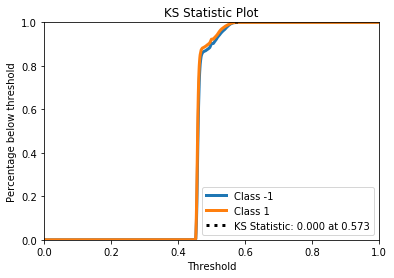

Accuracy: 0.4892557446474786
Precision: 0.45136887608069165
Recall: 0.09823598588788711
F-Measure: 0.16135470993496878
AUROC: 0.5588418480000229
AUPR: 0.5393389584828175
Confusion Matrix:
[[11224  1523]
 [11502  1253]]

[LibSVM]

/Users/rlsma/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


K Fold it 2


/Users/rlsma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


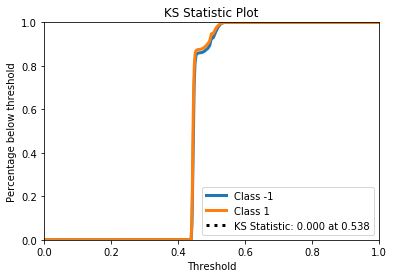

Accuracy: 0.48902046898282486
Precision: 0.45050215208034433
Recall: 0.09847118776950216
F-Measure: 0.1616161616161616
AUROC: 0.5653297443842482
AUPR: 0.5547019011051626
Confusion Matrix:
[[11215  1532]
 [11499  1256]]

[LibSVM]

/Users/rlsma/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


K Fold it 3


/Users/rlsma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


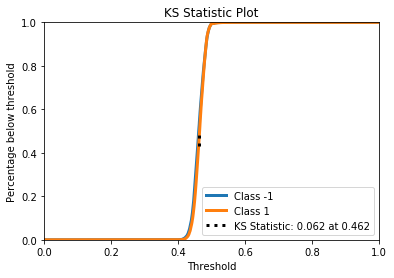

Accuracy: 0.5088820046272695
Precision: 0.5201676270298585
Recall: 0.23355546844374755
F-Measure: 0.3223677091223894
AUROC: 0.4658682629574013
AUPR: 0.46780470997085666
Confusion Matrix:
[[9998 2748]
 [9776 2979]]

[LibSVM]

/Users/rlsma/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


K Fold it 4


/Users/rlsma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


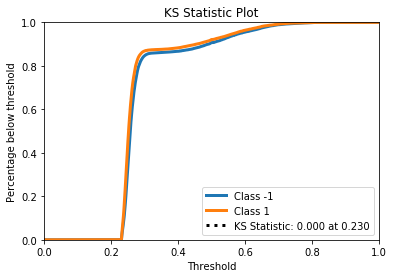

Accuracy: 0.4917846358966315
Precision: 0.46162485960314487
Recall: 0.09666797334378675
F-Measure: 0.15985997666277713
AUROC: 0.566582338527216
AUPR: 0.5523706865901324
Confusion Matrix:
[[11308  1438]
 [11522  1233]]

[LibSVM]

/Users/rlsma/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


K Fold it 5


/Users/rlsma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


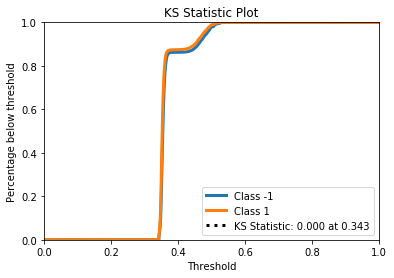

Accuracy: 0.4903729265518999
Precision: 0.39075249320036265
Recall: 0.0337906703253626
F-Measure: 0.06220233799971135
AUROC: 0.5727784976838107
AUPR: 0.5593665115077675
Confusion Matrix:
[[12074   672]
 [12324   431]]



/Users/rlsma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


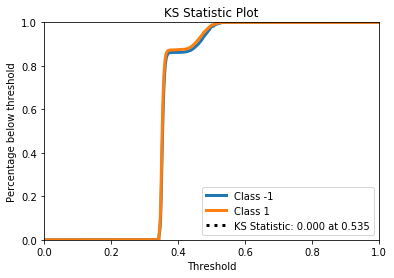

Accuracy: 0.34963360363415863
Precision: 0.5633658286300667
Recall: 0.034434095399379056
F-Measure: 0.0649012885683887
AUROC: 0.5553688646571611
AUPR: 0.6973837129816691
Confusion Matrix:
[[31823  1702]
 [61578  2196]]


/Users/rlsma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


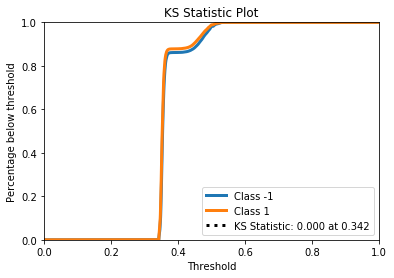

Accuracy: 0.3493252756965642
Precision: 0.5611264640084221
Recall: 0.033430289535786244
F-Measure: 0.06310119276644863
AUROC: 0.555505219927825
AUPR: 0.6960696302227896
Confusion Matrix:
[[ 63714   3335]
 [123285   4264]]


In [15]:
# Train SVM with k fold 

params = {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

svm_clf = svm.SVC(**params, decision_function_shape='ovo', 
              verbose=True, max_iter=200, probability=True)

_y_train = np.array([v if v == 1 else -1 for v in y_train])

train_test_k_fold(5, svm_clf, X_train, _y_train)

_y_val = np.array([v if v == 1 else -1 for v in y_val])
test_model(svm_clf, X_val, _y_val)

_y_test = np.array([v if v == 1 else -1 for v in y_test])
test_model(svm_clf, X_test, _y_test)

/Users/rlsma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


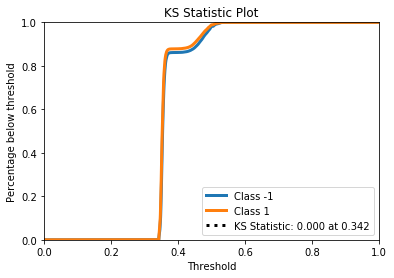

/Users/rlsma/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


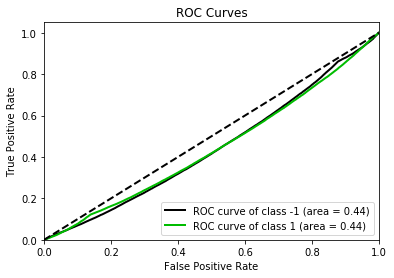

Accuracy: 0.3493252756965642
Precision: 0.5611264640084221
Recall: 0.033430289535786244
F-Measure: 0.06310119276644863
AUROC: 0.555505219927825
AUPR: 0.6960696302227896
Confusion Matrix:
[[ 63714   3335]
 [123285   4264]]


In [51]:
test_model(svm_clf, X_test, _y_test)

In [ ]:
# Run grid search to find best parameters
'''
    Best parameters found:
        Solver: adam
        hidden_layers: (12,12)
        learning_rate: 0.005
'''


'''solvers = ['lbfgs', 'adam',]
hidden_layers = [(12,12), (12,12,12), (5,5,5), (5,5)]
learning_rates = [.001, .0001, .005]

clf = MLPClassifier()
grid = GridSearchCV(estimator=clf, param_grid=dict(solver=solvers, hidden_layer_sizes=hidden_layers, learning_rate_init=learning_rates))
search = grid.fit(X_train, y_train)
'''

# parameters = {'solver': ['adam'], 'max_iter': [200,300,400,500,600,1000,2000], 'alpha': 10.0 ** -np.arange(1, 10), 'hidden_layer_sizes':np.arange(10, 15), 'random_state':[0,1,2,3,4,5,6,7,8,9]}
# grid = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1)
# search = grid.fit(X_train, y_train)

In [31]:
# Rename best parameters found on grid search

# params = search.best_params_

params = {
    'solver': 'adam',
    'hidden_layer_sizes': (50,50,50),
    'learning_rate_init': .03,
    'max_iter': 500,
}

Iteration 1, loss = 0.65808427
Iteration 2, loss = 0.64264771
Iteration 3, loss = 0.63854996
Iteration 4, loss = 0.63631823
Iteration 5, loss = 0.63587017
Iteration 6, loss = 0.63598760
Iteration 7, loss = 0.63454092
Iteration 8, loss = 0.63484011
Iteration 9, loss = 0.63551906
Iteration 10, loss = 0.63406257
Iteration 11, loss = 0.63401424
Iteration 12, loss = 0.63326066
Iteration 13, loss = 0.63302844
Iteration 14, loss = 0.63372057
Iteration 15, loss = 0.63332415
Iteration 16, loss = 0.63254596
Iteration 17, loss = 0.63170121
Iteration 18, loss = 0.63276232
Iteration 19, loss = 0.63355145
Iteration 20, loss = 0.63193667
Iteration 21, loss = 0.63217805
Iteration 22, loss = 0.63209839
Iteration 23, loss = 0.63082744
Iteration 24, loss = 0.63452369
Iteration 25, loss = 0.63486218
Iteration 26, loss = 0.63466231
Iteration 27, loss = 0.63394932
Iteration 28, loss = 0.63449122
Iteration 29, loss = 0.63652092
Iteration 30, loss = 0.63420705
Iteration 31, loss = 0.63305237
Iteration 32, los

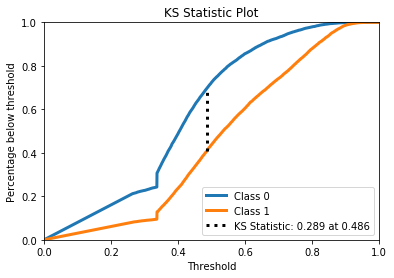

Accuracy: 0.6431260293310329
Precision: 0.6706838565022422
Recall: 0.5628381027048216
F-Measure: 0.6120465492987767
AUROC: 0.532025592173985
AUPR: 0.5849632647949775
Confusion Matrix:
[[9222 3525]
 [5576 7179]]

Iteration 1, loss = 0.66297848
Iteration 2, loss = 0.64875822
Iteration 3, loss = 0.64256379
Iteration 4, loss = 0.64041460
Iteration 5, loss = 0.63969249
Iteration 6, loss = 0.64175746
Iteration 7, loss = 0.63877795
Iteration 8, loss = 0.63970053
Iteration 9, loss = 0.63905041
Iteration 10, loss = 0.63864857
Iteration 11, loss = 0.63888318
Iteration 12, loss = 0.63846766
Iteration 13, loss = 0.63899852
Iteration 14, loss = 0.63841106
Iteration 15, loss = 0.63871692
Iteration 16, loss = 0.63929733
Iteration 17, loss = 0.63816273
Iteration 18, loss = 0.63733433
Iteration 19, loss = 0.63827686
Iteration 20, loss = 0.63835671
Iteration 21, loss = 0.63704778
Iteration 22, loss = 0.63880236
Iteration 23, loss = 0.63744539
Iteration 24, loss = 0.63752857
Iteration 25, loss = 0.637964

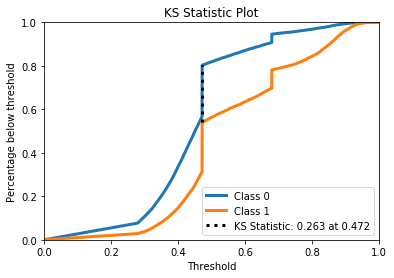

Accuracy: 0.6278331111285389
Precision: 0.7067916877850988
Recall: 0.4373186985495884
F-Measure: 0.540320627694096
AUROC: 0.5466977895076317
AUPR: 0.5991545516425769
Confusion Matrix:
[[10433  2314]
 [ 7177  5578]]

Iteration 1, loss = 0.66161085
Iteration 2, loss = 0.65226409
Iteration 3, loss = 0.64611420
Iteration 4, loss = 0.64093030
Iteration 5, loss = 0.63898459
Iteration 6, loss = 0.63968505
Iteration 7, loss = 0.64037285
Iteration 8, loss = 0.63982865
Iteration 9, loss = 0.63837656
Iteration 10, loss = 0.63757537
Iteration 11, loss = 0.63865909
Iteration 12, loss = 0.63805493
Iteration 13, loss = 0.63768964
Iteration 14, loss = 0.63783255
Iteration 15, loss = 0.63706124
Iteration 16, loss = 0.63704259
Iteration 17, loss = 0.63722011
Iteration 18, loss = 0.63757147
Iteration 19, loss = 0.63801699
Iteration 20, loss = 0.63689509
Iteration 21, loss = 0.63650724
Iteration 22, loss = 0.63720082
Iteration 23, loss = 0.63672860
Iteration 24, loss = 0.63667715
Iteration 25, loss = 0.63

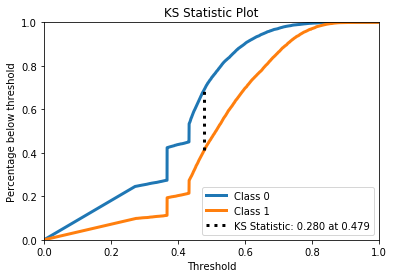

Accuracy: 0.638053409670209
Precision: 0.6756702880494369
Recall: 0.5314778518228146
F-Measure: 0.5949622608390381
AUROC: 0.4875387997298235
AUPR: 0.5178076446594696
Confusion Matrix:
[[9492 3254]
 [5976 6779]]

Iteration 1, loss = 0.66211559
Iteration 2, loss = 0.64734744
Iteration 3, loss = 0.64098356
Iteration 4, loss = 0.63788431
Iteration 5, loss = 0.63644545
Iteration 6, loss = 0.63616581
Iteration 7, loss = 0.63555640
Iteration 8, loss = 0.63675448
Iteration 9, loss = 0.63647556
Iteration 10, loss = 0.63578379
Iteration 11, loss = 0.63604300
Iteration 12, loss = 0.63684832
Iteration 13, loss = 0.63578128
Iteration 14, loss = 0.63510492
Iteration 15, loss = 0.63561808
Iteration 16, loss = 0.63561916
Iteration 17, loss = 0.63567251
Iteration 18, loss = 0.63675884
Iteration 19, loss = 0.63496206
Iteration 20, loss = 0.63543063
Iteration 21, loss = 0.63598223
Iteration 22, loss = 0.63579622
Iteration 23, loss = 0.63694481
Iteration 24, loss = 0.63600766
Iteration 25, loss = 0.635840

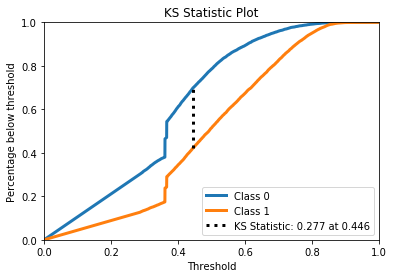

Accuracy: 0.6353476334261402
Precision: 0.6932885906040268
Recall: 0.4859270874166993
F-Measure: 0.5713758930629177
AUROC: 0.49046952294024126
AUPR: 0.5364543929348111
Confusion Matrix:
[[10004  2742]
 [ 6557  6198]]

Iteration 1, loss = 0.66139806
Iteration 2, loss = 0.64497546
Iteration 3, loss = 0.64022726
Iteration 4, loss = 0.63855186
Iteration 5, loss = 0.63841602
Iteration 6, loss = 0.63796520
Iteration 7, loss = 0.63695932
Iteration 8, loss = 0.63757240
Iteration 9, loss = 0.63732206
Iteration 10, loss = 0.63768867
Iteration 11, loss = 0.63837460
Iteration 12, loss = 0.63824624
Iteration 13, loss = 0.63670648
Iteration 14, loss = 0.63712738
Iteration 15, loss = 0.63718358
Iteration 16, loss = 0.63754870
Iteration 17, loss = 0.63710231
Iteration 18, loss = 0.63677090
Iteration 19, loss = 0.63666584
Iteration 20, loss = 0.63798652
Iteration 21, loss = 0.63634895
Iteration 22, loss = 0.63749498
Iteration 23, loss = 0.63769548
Iteration 24, loss = 0.63726985
Iteration 25, loss = 0.

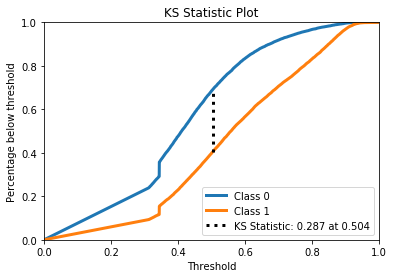

Accuracy: 0.6435826046037411
Precision: 0.6566398906169886
Recall: 0.6024304194433555
F-Measure: 0.6283681563560536
AUROC: 0.5649863450908235
AUPR: 0.6173304240837805
Confusion Matrix:
[[8728 4018]
 [5071 7684]]



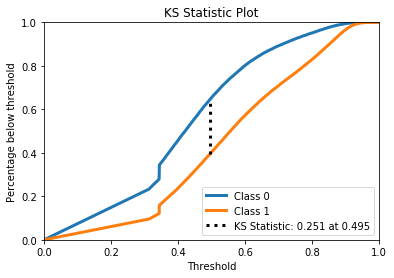

Accuracy: 0.6167483735701292
Precision: 0.7663635997908034
Recall: 0.5974064665851287
F-Measure: 0.6714190046524744
AUROC: 0.5522490596279035
AUPR: 0.7294351735801243
Confusion Matrix:
[[21910 11615]
 [25675 38099]]


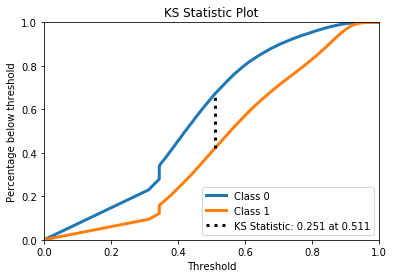

Accuracy: 0.6159056105407045
Precision: 0.7656481099518055
Recall: 0.5966099303012959
F-Measure: 0.6706413205368867
AUROC: 0.5552158910596315
AUPR: 0.7317238853508478
Confusion Matrix:
[[43757 23292]
 [51452 76097]]


In [32]:
# Train MLP with best parameters found on grid search
mlp = MLPClassifier(**params, alpha=1e-4, verbose=True, activation='relu', batch_size=128, tol=1e-7, random_state=9)

# Uncomment below line to run k fold on the MLP
train_test_k_fold(5, mlp, X_train, y_train)

test_model(mlp, X_val, y_val)

test_model(mlp, X_test, y_test)

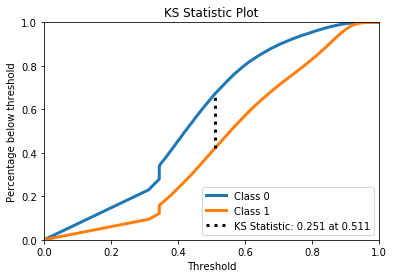

/Users/rlsma/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


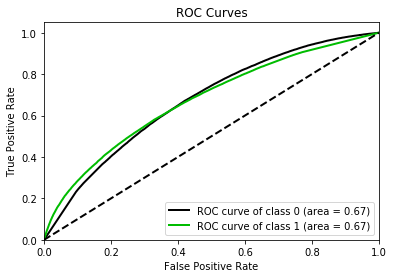

Accuracy: 0.6159056105407045
Precision: 0.7656481099518055
Recall: 0.5966099303012959
F-Measure: 0.6706413205368867
AUROC: 0.5552158910596315
AUPR: 0.7317238853508478
Confusion Matrix:
[[43757 23292]
 [51452 76097]]


In [49]:
test_model(mlp, X_test, y_test)

In [ ]:
# Train Keras MLP

'''input_dims = X_train.shape

model = Sequential()
model.add(Dense(1, input_dim=input_dims[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer='adam')

X_train, y_train = shuffle(X_train, y_train)
X_val, y_val = shuffle(X_val, y_val)
X_val, y_val = np.array(X_val), np.array(y_val)

history = model.fit(X_train, y_train, epochs=2, shuffle=True, batch_size=128, validation_data=(X_val, y_val))
'''

/Users/rlsma/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


K Fold it 1


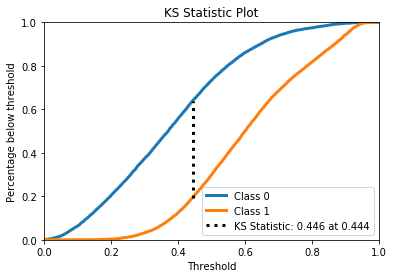

Accuracy: 0.7171986510861893
Precision: 0.7245038477116241
Recall: 0.7012152097216777
F-Measure: 0.7126693227091633
AUROC: 0.44689682328002284
AUPR: 0.46188218301091943
Confusion Matrix:
[[9346 3401]
 [3811 8944]]



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


K Fold it 2


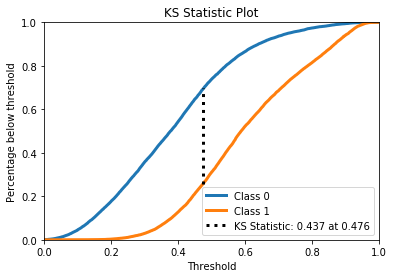

Accuracy: 0.7140224296133637
Precision: 0.7251442704039571
Recall: 0.6896119168953352
F-Measure: 0.7069318866787222
AUROC: 0.4566218223320745
AUPR: 0.47926202760959596
Confusion Matrix:
[[9413 3334]
 [3959 8796]]



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


K Fold it 3


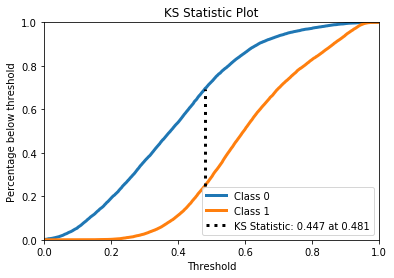

Accuracy: 0.7188345555076272
Precision: 0.72242134607726
Recall: 0.71109368874951
F-Measure: 0.7167127617542473
AUROC: 0.4457052467340812
AUPR: 0.4642962190080607
Confusion Matrix:
[[9261 3485]
 [3685 9070]]



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


K Fold it 4


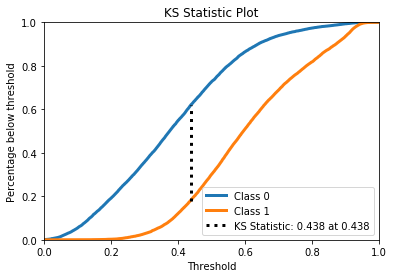

Accuracy: 0.7131877181287009
Precision: 0.7192360383592554
Recall: 0.6997255978047824
F-Measure: 0.7093466857415356
AUROC: 0.451563525390676
AUPR: 0.46893665887828734
Confusion Matrix:
[[9262 3484]
 [3830 8925]]



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


K Fold it 5


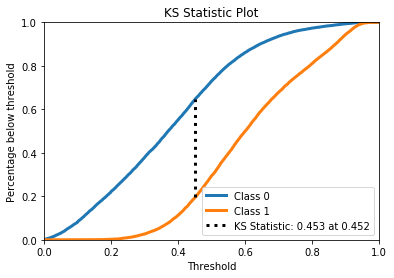

Accuracy: 0.7178934159444728
Precision: 0.7231361848968783
Recall: 0.706468051744414
F-Measure: 0.7147049492385786
AUROC: 0.4413479716436508
AUPR: 0.4519407599950763
Confusion Matrix:
[[9296 3450]
 [3744 9011]]



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


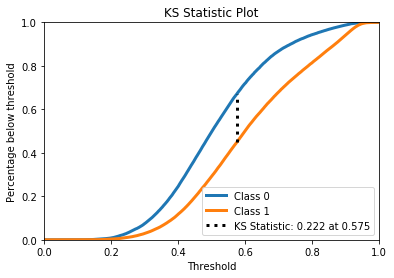

Accuracy: 0.6359366488864223
Precision: 0.7281183115817255
Recall: 0.7094740803462226
F-Measure: 0.7186752968272246
AUROC: 0.5842071095715583
AUPR: 0.7450847808241932
Confusion Matrix:
[[16630 16895]
 [18528 45246]]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


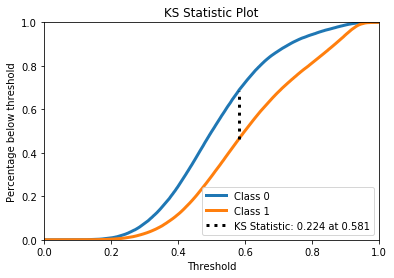

Accuracy: 0.6351504126455565
Precision: 0.7278477952552862
Recall: 0.708143536993626
F-Measure: 0.717860478054402
AUROC: 0.5852859501879037
AUPR: 0.7458638829284644
Confusion Matrix:
[[33276 33773]
 [37226 90323]]


In [26]:
rn = RandomForestClassifier(verbose=True, max_depth=15)

train_test_k_fold(5, rn, X_train, y_train)

test_model(rn, X_val, y_val)

test_model(rn, X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


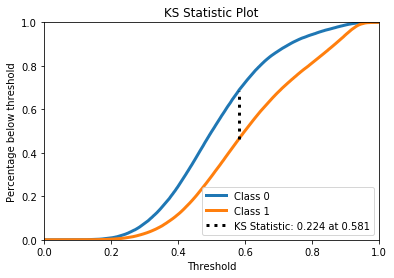

/Users/rlsma/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


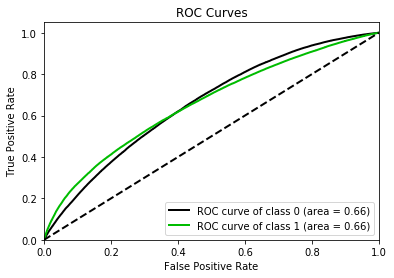

Accuracy: 0.6351504126455565
Precision: 0.7278477952552862
Recall: 0.708143536993626
F-Measure: 0.717860478054402
AUROC: 0.5852859501879037
AUPR: 0.7458638829284644
Confusion Matrix:
[[33276 33773]
 [37226 90323]]


In [50]:
test_model(rn, X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


K Fold it 1


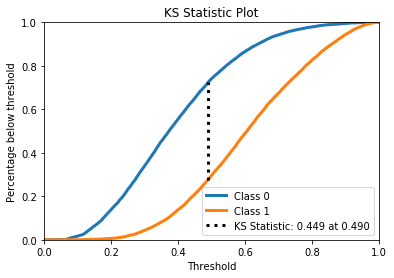

Accuracy: 0.722257077876245
Precision: 0.7308318411199739
Recall: 0.7039592316738534
F-Measure: 0.7171438840301904
AUROC: 0.4848616243076018
AUPR: 0.5255074418241739
Confusion Matrix:
[[9440 3307]
 [3776 8979]]



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


K Fold it 2


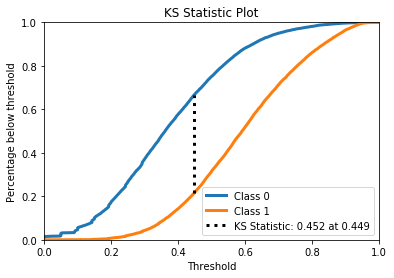

Accuracy: 0.7184534546310093
Precision: 0.7337134233252285
Recall: 0.6860838886711094
F-Measure: 0.7090997488047971
AUROC: 0.444093513429052
AUPR: 0.45781702914178146
Confusion Matrix:
[[9571 3176]
 [4004 8751]]



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


K Fold it 3


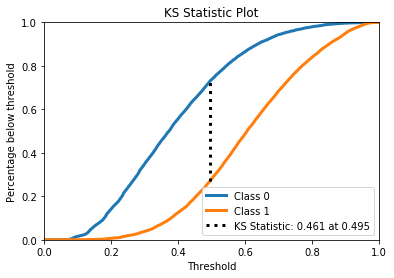

Accuracy: 0.7291870907023253
Precision: 0.7326386126799778
Recall: 0.7220697765582125
F-Measure: 0.7273158019426675
AUROC: 0.4736711767223088
AUPR: 0.5159656743037618
Confusion Matrix:
[[9385 3361]
 [3545 9210]]



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


K Fold it 4


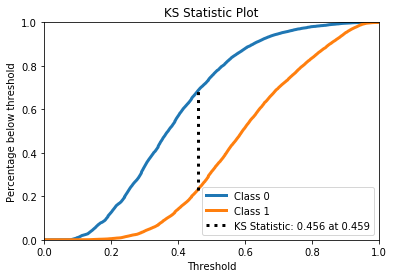

Accuracy: 0.7195796243284577
Precision: 0.7349882589734988
Recall: 0.6871030968247746
F-Measure: 0.7102394748571659
AUROC: 0.4720618663741088
AUPR: 0.5221333147613276
Confusion Matrix:
[[9586 3160]
 [3991 8764]]



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


K Fold it 5


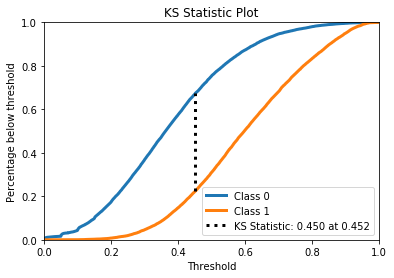

Accuracy: 0.7217364024940198
Precision: 0.7365604882534905
Recall: 0.6907095256762054
F-Measure: 0.7128985272697848
AUROC: 0.4605928559965746
AUPR: 0.47401458545979247
Confusion Matrix:
[[9595 3151]
 [3945 8810]]



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


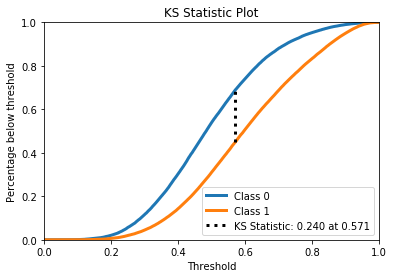

Accuracy: 0.6379716132745454
Precision: 0.7399035310330919
Recall: 0.6903283469752564
F-Measure: 0.7142567430541472
AUROC: 0.5734123516471417
AUPR: 0.7355474433566204
Confusion Matrix:
[[18049 15476]
 [19749 44025]]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


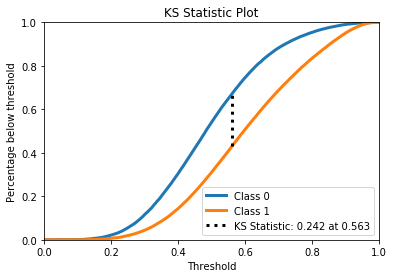

Accuracy: 0.6385060483663758
Precision: 0.7406986627618303
Recall: 0.690048530368721
F-Measure: 0.714477059453843
AUROC: 0.5760292877175403
AUPR: 0.7372213767902086
Confusion Matrix:
[[36237 30812]
 [39534 88015]]


In [19]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

eclf = VotingClassifier(estimators=[('rn', rn), ('mlp', mlp)], voting='soft', n_jobs=-1)

train_test_k_fold(5, eclf, X_train, y_train)

test_model(eclf, X_val, y_val)

test_model(eclf, X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


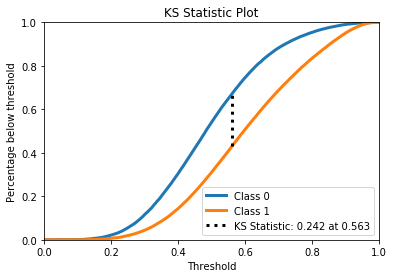

/Users/rlsma/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


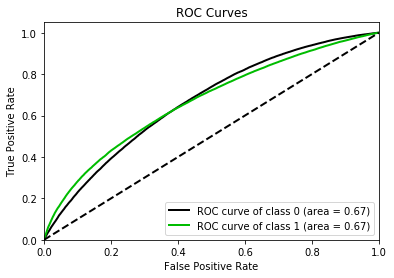

Accuracy: 0.6385060483663758
Precision: 0.7406986627618303
Recall: 0.690048530368721
F-Measure: 0.714477059453843
AUROC: 0.5760292877175403
AUPR: 0.7372213767902086
Confusion Matrix:
[[36237 30812]
 [39534 88015]]


In [53]:
test_model(eclf, X_test, y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  7.9min remaining:  7.9min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  9.4min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.1s remaining:    1.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.0s finished


K Fold it 1


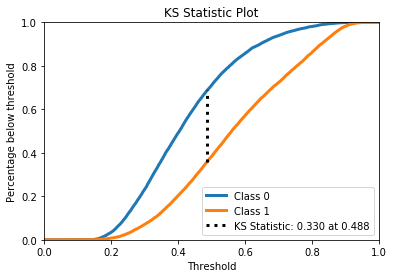

Accuracy: 0.6630068229942749
Precision: 0.6797408207343413
Recall: 0.6168561348490788
F-Measure: 0.6467735306206329
AUROC: 0.5272365359592839
AUPR: 0.5793743188992305
Confusion Matrix:
[[9040 3707]
 [4887 7868]]



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  8.2min remaining:  8.2min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 12.3min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.1s remaining:    1.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.2s finished


K Fold it 2


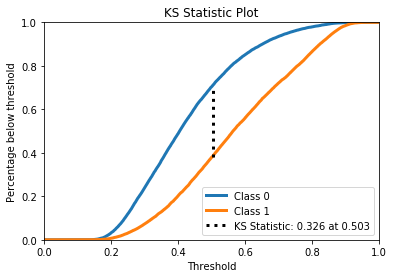

Accuracy: 0.6624186338326405
Precision: 0.6770281810418446
Recall: 0.6215601724813798
F-Measure: 0.6481095442468833
AUROC: 0.5293438134435333
AUPR: 0.5780727467333556
Confusion Matrix:
[[8965 3782]
 [4827 7928]]



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  8.2min remaining:  8.2min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 10.5min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.4s remaining:    2.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.3s finished


K Fold it 3


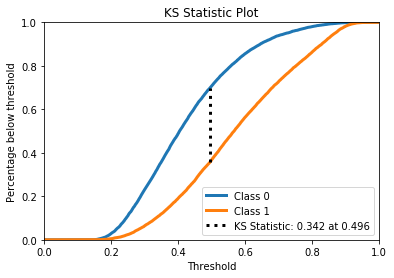

Accuracy: 0.6701697972628524
Precision: 0.6838496698831894
Recall: 0.6333986671893375
F-Measure: 0.6576580243396148
AUROC: 0.5243214479844193
AUPR: 0.5769362609192039
Confusion Matrix:
[[9011 3735]
 [4676 8079]]



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  8.9min remaining:  8.9min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 10.2min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.1s finished


K Fold it 4


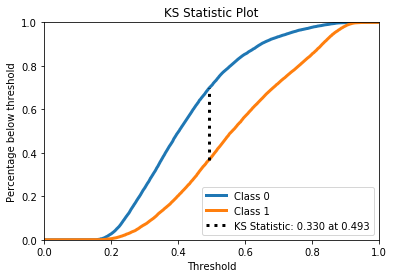

Accuracy: 0.664052390102349
Precision: 0.6804550155118925
Recall: 0.6190513524108193
F-Measure: 0.6483024754710784
AUROC: 0.5270229111777974
AUPR: 0.5811446815712696
Confusion Matrix:
[[9038 3708]
 [4859 7896]]



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed: 10.0min remaining: 10.0min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 11.1min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.2s finished


K Fold it 5


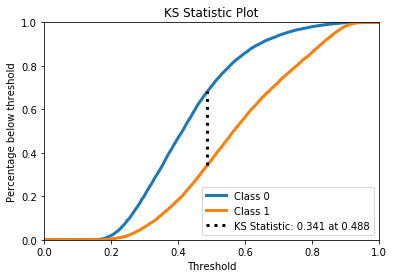

Accuracy: 0.6694247284420218
Precision: 0.6827825204969994
Recall: 0.6333202665621325
F-Measure: 0.6571219393150574
AUROC: 0.53568739838166
AUPR: 0.5863879322840408
Confusion Matrix:
[[8993 3753]
 [4677 8078]]



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    4.4s remaining:    4.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.1s remaining:    5.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.8s finished


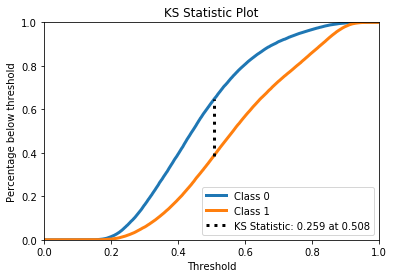

Accuracy: 0.628927327105109
Precision: 0.7638510098602025
Recall: 0.6280145513845767
F-Measure: 0.6893044308862633
AUROC: 0.5454661491419166
AUPR: 0.7223459557430367
Confusion Matrix:
[[21143 12382]
 [23723 40051]]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    8.4s remaining:    8.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   10.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    7.4s remaining:    7.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    9.3s finished


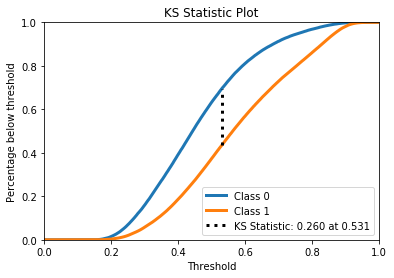

Accuracy: 0.6285727499768754
Precision: 0.764020254132034
Recall: 0.6269747312797435
F-Measure: 0.6887463988734771
AUROC: 0.5483478835718292
AUPR: 0.724222990919044
Confusion Matrix:
[[42349 24700]
 [47579 79970]]


In [20]:
mlp_ensemble = BaggingClassifier(base_estimator=mlp, n_jobs=-1, verbose=True)

train_test_k_fold(5, mlp_ensemble, X_train, y_train)

test_model(mlp_ensemble, X_val, y_val)

test_model(mlp_ensemble, X_test, y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   11.4s remaining:   11.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   13.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   10.9s remaining:   10.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   13.3s finished


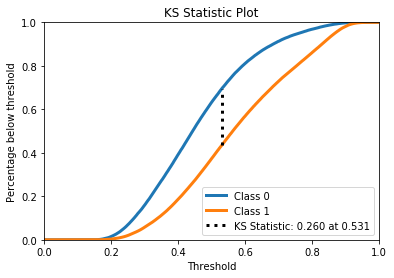

/Users/rlsma/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


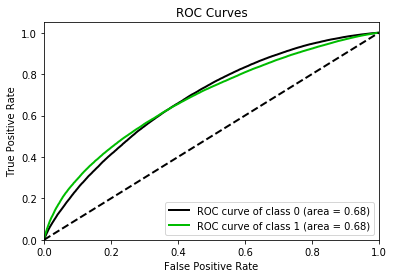

Accuracy: 0.6285727499768754
Precision: 0.764020254132034
Recall: 0.6269747312797435
F-Measure: 0.6887463988734771
AUROC: 0.5483478835718292
AUPR: 0.724222990919044
Confusion Matrix:
[[42349 24700]
 [47579 79970]]


In [52]:
test_model(mlp_ensemble, X_test, y_test)

      Iter       Train Loss   Remaining Time 
         1           1.3560            9.06m
         2           1.3243            8.11m
         3           1.3004            8.01m
         4           1.2787            7.98m
         5           1.2626            7.86m
         6           1.2439            7.54m
         7           1.2284            7.32m
         8           1.2133            7.14m
         9           1.2009            6.98m
        10           1.1873            6.74m
        20           1.0988            5.38m
        30           1.0498            4.45m
        40           1.0149            3.69m
        50           0.9916            3.01m
        60           0.9734            2.36m
        70           0.9609            1.76m
        80           0.9497            1.16m
        90           0.9388           34.33s
       100           0.9285            0.00s
K Fold it 1


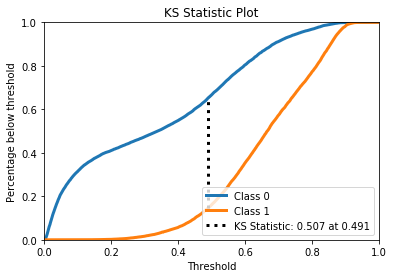

Accuracy: 0.7526860638381303
Precision: 0.7152777777777778
Recall: 0.8398275186201489
F-Measure: 0.7725649994590891
AUROC: 0.38078347548252106
AUPR: 0.40290804891536236
Confusion Matrix:
[[ 8483  4264]
 [ 2043 10712]]

      Iter       Train Loss   Remaining Time 
         1           1.3557            6.15m
         2           1.3241            6.42m
         3           1.3011            6.12m
         4           1.2773            6.27m
         5           1.2581            6.08m
         6           1.2400            6.08m
         7           1.2261            5.95m
         8           1.2141            6.03m
         9           1.1971            5.95m
        10           1.1827            5.90m
        20           1.0956            5.04m
        30           1.0459            4.78m
        40           1.0105            4.32m
        50           0.9874            3.56m
        60           0.9682            2.79m
        70           0.9552            2.02m
        80     

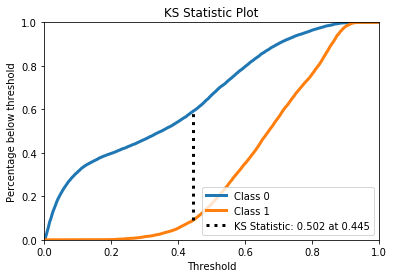

Accuracy: 0.7509607089640028
Precision: 0.7144100709789741
Recall: 0.8364562916503332
F-Measure: 0.7706309364729677
AUROC: 0.38324339895103565
AUPR: 0.4043670077720053
Confusion Matrix:
[[ 8482  4265]
 [ 2086 10669]]

      Iter       Train Loss   Remaining Time 
         1           1.3559            5.54m
         2           1.3241            5.59m
         3           1.2978            5.58m
         4           1.2763            5.51m
         5           1.2556            5.47m
         6           1.2402            5.43m
         7           1.2254            5.47m
         8           1.2103            5.52m
         9           1.1983            5.66m
        10           1.1831            5.66m
        20           1.0967            5.26m
        30           1.0479            4.76m
        40           1.0139            4.03m
        50           0.9936            3.25m
        60           0.9744            2.61m
        70           0.9582            1.93m
        80      

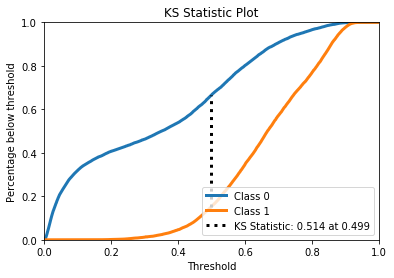

Accuracy: 0.756911493666915
Precision: 0.7173740053050398
Recall: 0.8481379851038808
F-Measure: 0.7772947727680978
AUROC: 0.3822155872084573
AUPR: 0.40361457242956944
Confusion Matrix:
[[ 8484  4262]
 [ 1937 10818]]

      Iter       Train Loss   Remaining Time 
         1           1.3556            5.49m
         2           1.3239            5.58m
         3           1.3005            5.50m
         4           1.2768            5.46m
         5           1.2602            5.37m
         6           1.2445            5.29m
         7           1.2276            5.24m
         8           1.2135            5.17m
         9           1.1973            5.12m
        10           1.1864            5.07m
        20           1.0972            4.56m
        30           1.0462            4.08m
        40           1.0106            3.46m
        50           0.9881            2.96m
        60           0.9694            2.33m
        70           0.9557            1.72m
        80       

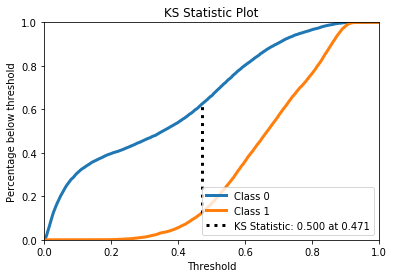

Accuracy: 0.7477353829261597
Precision: 0.7114664169119614
Recall: 0.8337906703253626
F-Measure: 0.767786882287117
AUROC: 0.3859531399709537
AUPR: 0.4054962247744025
Confusion Matrix:
[[ 8433  4313]
 [ 2120 10635]]

      Iter       Train Loss   Remaining Time 
         1           1.3562           10.18m
         2           1.3244            9.46m
         3           1.3015            9.11m
         4           1.2776            8.25m
         5           1.2584            7.65m
         6           1.2447            7.29m
         7           1.2291            7.31m
         8           1.2109            7.22m
         9           1.1965            7.09m
        10           1.1826            6.84m
        20           1.0980            5.36m
        30           1.0508            4.45m
        40           1.0157            3.70m
        50           0.9908            3.02m
        60           0.9741            2.38m
        70           0.9592            1.76m
        80        

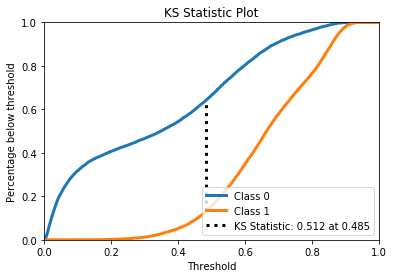

Accuracy: 0.7551860711344653
Precision: 0.7162305751095763
Recall: 0.8455507644061152
F-Measure: 0.7755366195663899
AUROC: 0.3820841526719661
AUPR: 0.40347876195489035
Confusion Matrix:
[[ 8473  4273]
 [ 1970 10785]]



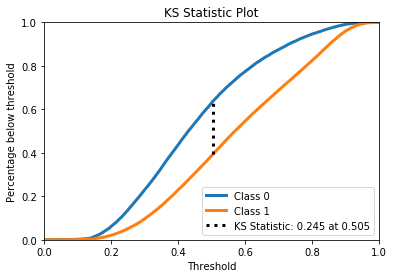

Accuracy: 0.6190505555041675
Precision: 0.7589992242048099
Recall: 0.6136356508922132
F-Measure: 0.6786203547956371
AUROC: 0.538912911311282
AUPR: 0.709024078539649
Confusion Matrix:
[[21099 12426]
 [24640 39134]]


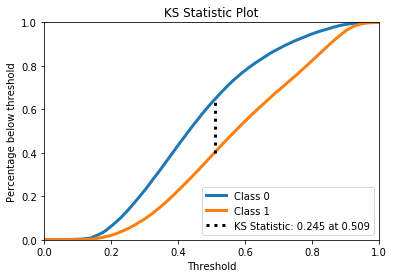

Accuracy: 0.6194462430240805
Precision: 0.7591763565891473
Recall: 0.614250209723322
F-Measure: 0.6790668648618196
AUROC: 0.5414393810340182
AUPR: 0.7098477608050531
Confusion Matrix:
[[42196 24853]
 [49202 78347]]


In [25]:
grad_boosting_clf = GradientBoostingClassifier(n_estimators=100, max_depth=5, verbose=True)
train_test_k_fold(5, grad_boosting_clf, X_train, y_train)

test_model(grad_boosting_clf, X_val, y_val)

test_model(grad_boosting_clf, X_test, y_test)

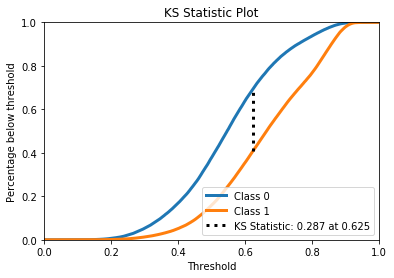

/Users/rlsma/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


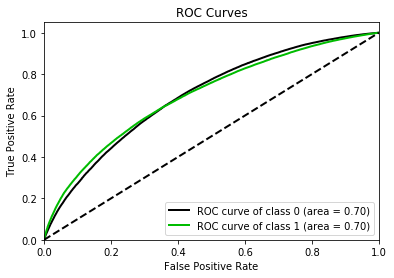

Accuracy: 0.6813276600992816
Precision: 0.7198751929141783
Recall: 0.8411120432147645
F-Measure: 0.7757855802501273
AUROC: 0.6405920353579799
AUPR: 0.780089934425428
Confusion Matrix:
[[ 25302  41747]
 [ 20266 107283]]


In [54]:
test_model(grad_boosting_clf, X_test, y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.9s remaining:    2.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.1s finished


K Fold it 1


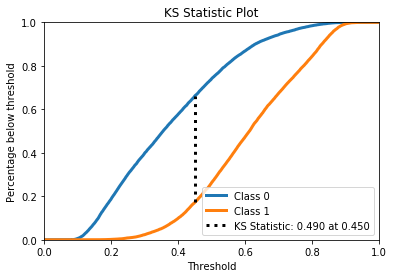

Accuracy: 0.739000862677437
Precision: 0.7395710582135282
Recall: 0.738063504508036
F-Measure: 0.7388165123214566
AUROC: 0.43825120902999076
AUPR: 0.46296989050232606
Confusion Matrix:
[[9432 3315]
 [3341 9414]]



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    3.2s remaining:    3.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.2s finished


K Fold it 2


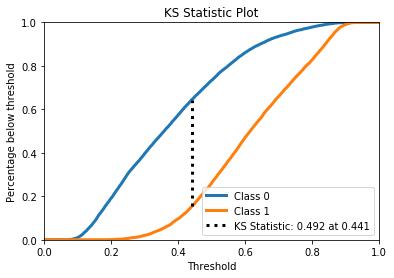

Accuracy: 0.7361775547015921
Precision: 0.7345318701844501
Recall: 0.7399451195609564
F-Measure: 0.7372285580378064
AUROC: 0.4397001106816104
AUPR: 0.4643653847144026
Confusion Matrix:
[[9336 3411]
 [3317 9438]]



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    4.1s remaining:    4.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.2s remaining:    1.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.3s finished


K Fold it 3


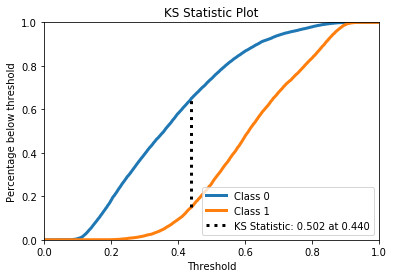

Accuracy: 0.7413826908748676
Precision: 0.7412658624471252
Recall: 0.7419051352410819
F-Measure: 0.7415853610751931
AUROC: 0.43567337410502205
AUPR: 0.4715666953225973
Confusion Matrix:
[[9443 3303]
 [3292 9463]]



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    4.0s remaining:    4.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.5s remaining:    1.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.0s finished


K Fold it 4


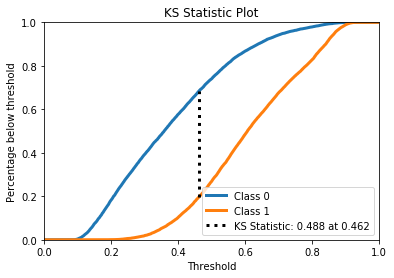

Accuracy: 0.7361672091290538
Precision: 0.7383155397390273
Recall: 0.7319482555860447
F-Measure: 0.7351181102362204
AUROC: 0.4400635324335694
AUPR: 0.47694891902022796
Confusion Matrix:
[[9437 3309]
 [3419 9336]]



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    3.6s remaining:    3.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.6s remaining:    1.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.9s finished


K Fold it 5


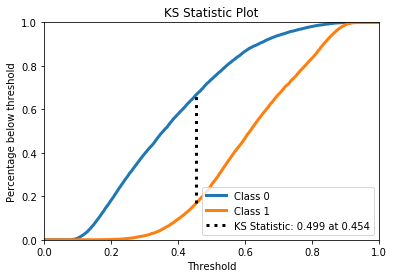

Accuracy: 0.7432649700011764
Precision: 0.7409563732339699
Recall: 0.7483339866718933
F-Measure: 0.7446269064243086
AUROC: 0.4386082184844518
AUPR: 0.4696663837147252
Confusion Matrix:
[[9409 3337]
 [3210 9545]]



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    4.9s remaining:    4.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.0s remaining:    6.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.0s finished


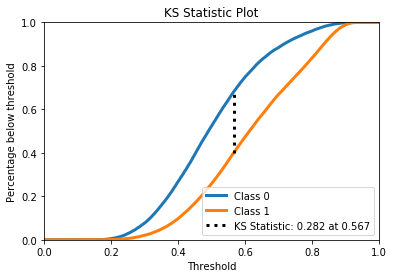

Accuracy: 0.666594723481228
Precision: 0.7472773761798036
Recall: 0.7424028600997271
F-Measure: 0.744832142969512
AUROC: 0.5970067593041021
AUPR: 0.7561224242808261
Confusion Matrix:
[[17513 16012]
 [16428 47346]]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   25.5s remaining:   25.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   27.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   10.0s remaining:   10.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   12.0s finished


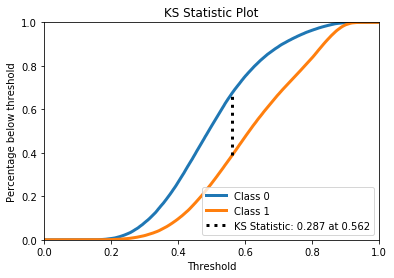

Accuracy: 0.6658855692247608
Precision: 0.7470780221430209
Recall: 0.7411739801958463
F-Measure: 0.7441142902121297
AUROC: 0.5982415741059367
AUPR: 0.7576597531517616
Confusion Matrix:
[[35044 32005]
 [33013 94536]]


In [27]:
eclf2 = VotingClassifier(estimators=[('mlp_ensemble', mlp_ensemble), ('gradient_boost', grad_boosting_clf)], voting='soft', n_jobs=-1)

train_test_k_fold(5, eclf2, X_train, y_train)

test_model(eclf2, X_val, y_val)

test_model(eclf2, X_test, y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   11.2s remaining:   11.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   13.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   10.8s finished


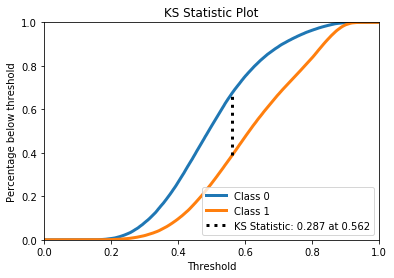

/Users/rlsma/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


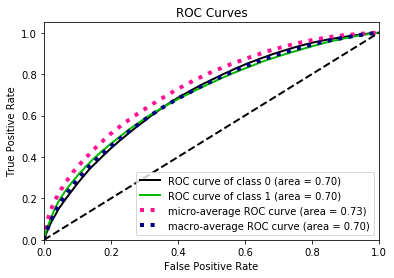

Accuracy: 0.6658855692247608
Precision: 0.7470780221430209
Recall: 0.7411739801958463
F-Measure: 0.7441142902121297
AUROC: 0.5982415741059367
AUPR: 0.7576597531517616
Confusion Matrix:
[[35044 32005]
 [33013 94536]]


In [36]:
test_model(eclf2, X_test, y_test)

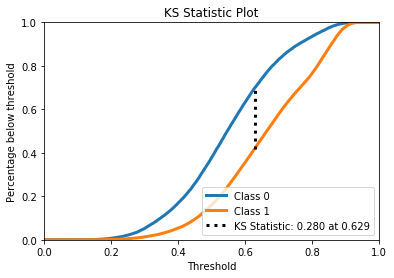

Accuracy: 0.6802330959208214
Precision: 0.7194399279753826
Recall: 0.8395270800012544
F-Measure: 0.774858350278234
AUROC: 0.6382412039606583
AUPR: 0.7780990732428646
Confusion Matrix:
[[12646 20879]
 [10234 53540]]


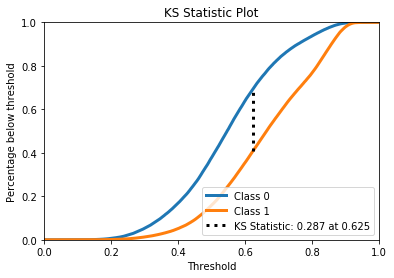

Accuracy: 0.6813276600992816
Precision: 0.7198751929141783
Recall: 0.8411120432147645
F-Measure: 0.7757855802501273
AUROC: 0.6405920353579799
AUPR: 0.780089934425428
Confusion Matrix:
[[ 25302  41747]
 [ 20266 107283]]


In [33]:
test_model(grad_boosting_clf, X_val, y_val)

test_model(grad_boosting_clf, X_test, y_test)